<a href="https://colab.research.google.com/github/bathicodes/Augmentic/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch workflow

1. Data (prepare and load).
2. Build model.
3. Fitting the model to the data (training).
4. Making predictions and evaluating the model.
5. Saving and loading a model.
6. Putting it all together.

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version

torch.__version__

'1.13.1+cu116'

# 1. Data (prepare and load).

Data can be anything:

1. Excel spreadsheet
2. Images of any kind 
3. Videos
4. Audios
5. DNA
6. Text

ML / DL is a task of two parts

1. Convert data into numerical values
2. Build a model to learn patterns in that numerical representation

Here generating **Known** data using linear regression equation.

`Y = mx + c`

In [2]:
# Create *Known* dataset

weight = 0.7
bias = 0.3

# Create data

start = 0
end = 1
steps = 0.02

X = torch.arange(start, end, steps).unsqueeze(dim=1)

y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
len(X), len(y)

(50, 50)

## Split dataset into training and test set

In [4]:
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

## Visualizing data

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  
  """
  Plots training data, test data, training labels, test labels and compare predictions
  """

  plt.figure(figsize=(10,7))

  # Plot trainng data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="orange", s=4, label="Testing data")

  # Are there predictions?
  if predictions is not None:
    
    # plot the predictions
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show legend
  plt.legend(prop={"size":14})

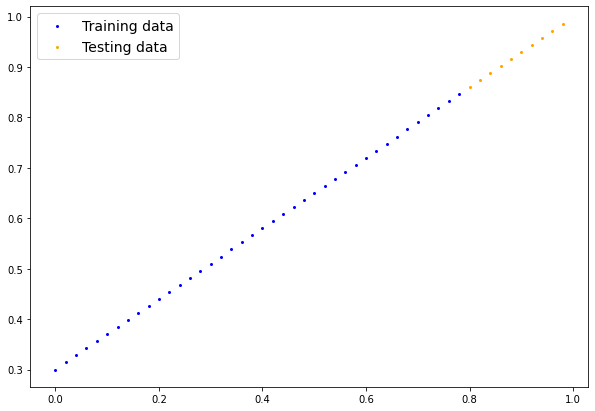

In [6]:
plot_predictions()

# Build model

This model will find the patterns for the above given dataset.

specisifically this model will find the best values for the `weights` and `bias`.

How it does so?

By using two algorithms:

1. Gradient descent
2. Backpropergation

# PyTorch model building essentials

* torch.nn - contains all the buildings for the computational graphs.
* torch.nn.Parameter - what parameters should our model try and learn, often PyTorch layer from torch.nn will set these for us.
* torch.nn.Module - The base class for all neural network modules, if we subclass it, we should override the forward()
* torch.optim - this where the optimizer in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require us to overwrite forward(), this method defines what happens in the forward computation

In [7]:
from torch import nn

# Create linear regression model class

class LinearRegressionModel(nn.Module): # <- Almost everything in PyTorch inherits from moduls

  def __init__(self):
    super().__init__()

    self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

  # Forward method to define computaions in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- here x is the input data
    return self.weights * x + self.bias # <- this is same as the linear regression formula

## Checking the contents in PyTorch model

Let's see whats inside the above model. we can check our model parameters using `.parameters().`

In [8]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

# Check out the parameters 
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# List named parameters

model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Making predictions using `torch.inference_mode()`

To check our models predictive power, let's see how well it predicts `y_test` based on `X_test`.

When we pass data through our model, It's going to run through the `forward()` method.

In [10]:
# Make predictions with model

with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

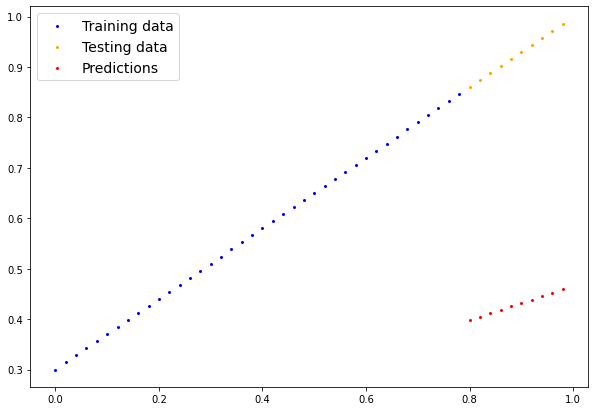

In [11]:
plot_predictions(predictions=y_preds)

## Train model

Idea of training is for a model to move from some unknown parameters to some known parameters. 

One way to meassure how wrong our model is to find the loss function.

Things we need to train.

* Loss function: A function to measure how wrong is our model from the ideal outputs (lower is better)

* Optimizer: Takes into account the loss of a model and adjust the model's parameter to improve the loss function (e.g. weights and bias)

And Specificaly for PyTorch, we need:

1. A training loop
2. A test loop

In [12]:
# Setup a loss function

loss_fn = nn.L1Loss() # mean absolute error (MAE)

# Setup a optimizer

optimizer = torch.optim.SGD(params=model_0.parameters(), # we want to optimize the parameters present in our model
                            lr=0.01) # lr = learning rate = possibly the most important hyperparameter we can set


## Building a training loop (and testing) in PyTorch

Things we need in the training loop:

0. Loop through data.
1. Forward pass (this invloves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation.
2. Calculate the loss (compare forward pass predictions to the ground truth labels).
3. Optimizer zero grad.
4. Loss backward - move backward through the network to calculate the gradients of each of the parameters of our model with respect to the loss. (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss. (**gradient descent**)



In [13]:
torch.manual_seed(42)

# An epoch is one loop through the data...
epochs = 200 

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all the parameters that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss 
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameter of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumilate through the loop. so we have to zero them above in step 3 for the next iteration of the loop

  # Testing
  model_0.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batchnorm)
  with torch.inference_mode(): # turns off the gradient tracking
    # 1. Do forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    # Print out model state_dict()
    print(model_0.state_dict())



Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

In [14]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

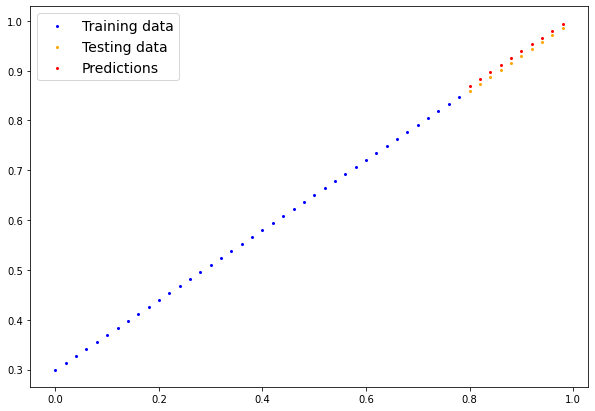

In [15]:
plot_predictions(predictions=y_preds_new)

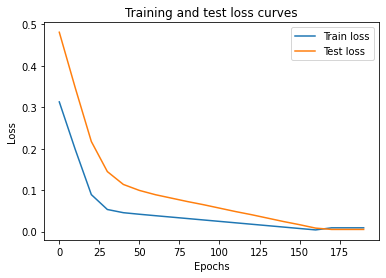

In [16]:
import numpy as np

# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

# Saving a model in PyTorch

There are three main methods we have to follow.

1. `torch.save()` - allows us to save a PyTorch object in python's pickle format.
2. `torch.load()` - allows us to load a saved PyTorch object.
3. `torch.nn.Module.load_state_dict()` - this allows us to load a model's saved state dictionary

In [17]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [18]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1207 Feb  2 14:29 01_pytorch_workflow_model_0.pth


# Loading a PyTorch model model

Since we saved our model's `state_dict()` rather than entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that

In [19]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [20]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [21]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [22]:
# Make some prediction with our loaded model 
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [23]:
# Make some prediction with our original model 
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [24]:
# Compare loaded model preds with original model preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# 6. Putting all together

Adding all the code blocks together

In [25]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'1.13.1+cu116'

Create device-agnostic code

If we got GPUs, our code will use it (for faster computing). If no GPU available, the code will default to using CPU.

In [26]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [27]:
!nvidia-smi

Thu Feb  2 14:29:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    27W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 6.1 Data

Creating dummy dataset

In [28]:
# Creating some dummy data using the linear regression formula of y = weights * X + bias
weights = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Creating X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weights * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [29]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(y_test), len(y_test)

(40, 40, 10, 10)

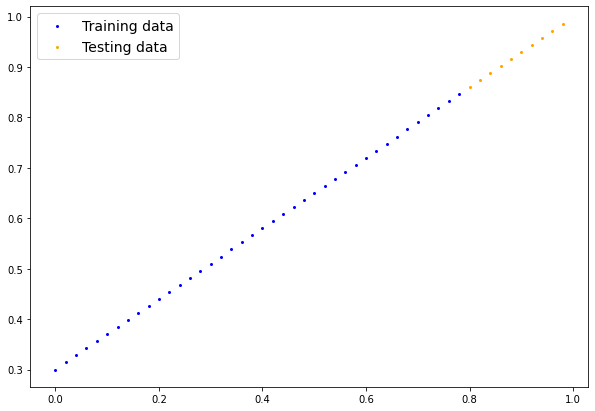

In [30]:
# Plot data
# Note: Load plot predictions method to the notebook

plot_predictions(X_train, y_train, X_test, y_test)

# 6.2 Build a PyTorch linear model

In [31]:
# Create a linear model by subclassing nn.Module

class LinearRegressionV2(nn.Module):
  def __init__(self):
    super().__init__()

    # Use nn.Linear() for creating the model parameters / also called: linear transform, probing layer, fully connected layer, dense layer
    self.linear_layer = nn.Linear(in_features=1, # provide how many features we are going to insert.
                                  out_features=1) # provide how many outputs we expected

    # 👆🏻 code is same as below two lines

    # self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    # self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

    # 👆🏻 code is same as below line

    # return self.weights * x + self.bias

# set the manual seed
torch.manual_seed(42)

model_1 = LinearRegressionV2()
model_1, model_1.state_dict()

(LinearRegressionV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [32]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [33]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

# 6.3 Training

For training we need:

1. Loss function
2. Optimimzer
3. Training loop
4. Testing loop

In [34]:
# Setup loss function
loss_fn = nn.L1Loss() # same as MAE

# Setup optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [35]:
# Training loop
torch.manual_seed(42)

epochs = 200

# Note above we have put model on the GPU, But now we have put the data tensor in the GPU too.

# Put data on the target device (device agnostic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# training loop 
for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval() #stop tracking dropout and batchnorm layers

  with torch.inference_mode():

    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

  # Print the status

  if epoch % 10 == 0:

    print(f"Epoch {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch 70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
Epoch 80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Epoch 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch 100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch 110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
Epoch 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch 130 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch 140 

In [36]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

# 6.4 Making and evalute predictions

In [37]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

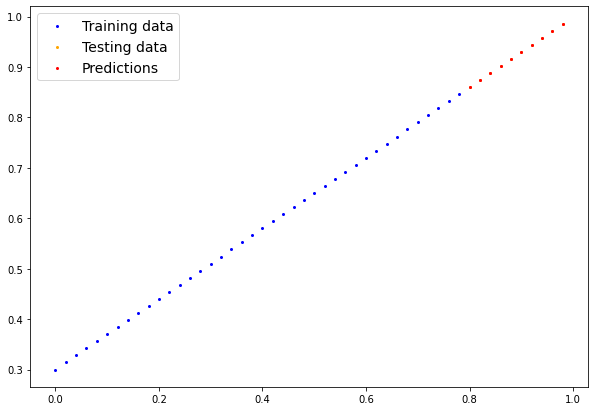

In [38]:
# plot our predictions
plot_predictions(predictions=y_preds.cpu().numpy())

# 6.5 Saving and loading a trained model

In [39]:
from pathlib import Path

# 1. Creates models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_01.pth"

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_01.pth


In [40]:
# Load a PyTorch model

# Create new instance
loaded_model_1 = LinearRegressionV2()

# Load the saved model_1 state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the laoded model to the device (GPU)
loaded_model_1.to(device)

LinearRegressionV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [41]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [42]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [43]:
# Evaluate loaded model
loaded_model_1.eval()

with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

loaded_model_1_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

In [44]:
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')